# EDA and Preprocessing

Here I'll be performing my initial exploratory analysis to get a feel for the data and see what some of the most common words and bigrams used in each subreddit page are.

**Note: In this notebook, I will be removing most, if not all, of the URLs in the dataframe for the purposes of cleaning. There is a second version of this project located in the appendix files that does not have the URLs removed. Extracting the links in this notebook did decrease the train and test scores seen in almost all model trials, but hopefully resulted in cleaner data and better interpretations overall.**

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import re
import spacy
import spacy.cli
from sklearn.feature_extraction import text 


from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

pd.options.display.max_colwidth = 200

In [2]:
# Reading in the saved CSV file

reddit = pd.read_csv('../datasets/reddit_all_columns_df.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
print(reddit.shape)
reddit[['subreddit', 'title', 'selftext']].iloc[list(range(5)) + list(range(-5,0))]

(1870, 89)


,subreddit,title,selftext
0,Ohio,About the Donovan Lewis police shooting in Columbus.,Donovan reacted as naturally as anyone would when strangers burst open your bedroom door. There is inherent risk when serving a warrant and going through someone’s home unwelcomed. Cops need to re...
1,Ohio,The chokehold JD Vance has on my YouTube ads.,"No matter how much you tell me about it, I’m not reading Hillbilly Elegy. But seriously, Tim Ryan needs to make an ad on there."
2,Ohio,Need wedding photographer plzzz,Hi everyone my fiancé and I booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . The past 2 weeks we have called then emailed even txted an...
3,Ohio,Ranked choice voting?,"Alaska seems to be doing well, when does Ohio follow."
4,Ohio,How long is the wait for a handgun purchased from Atlantic gun &amp; tackle,Not sure if this is the right place to be asking. But I recently just purchased a handgun from Atlantic gun &amp; tackle and they said I could get approved today in the next hour or it could be up...
1865,IHateOhio,Candle knows what’s up!,NaN
1866,IHateOhio,"Caught this monstrous DiWhy in SE MI, cherry on top was the license plate",NaN
1867,IHateOhio,Cuyahoga named River of the Year,NaN
1868,IHateOhio,Cursed_tribute,NaN
1869,IHateOhio,I hate Ohio,NaN


In [3]:
reddit['subreddit'].value_counts(normalize=True)

Ohio         0.515508
IHateOhio    0.484492
Name: subreddit, dtype: float64

In [4]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 89 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  1725 non-null   object 
 1   allow_live_comments            1676 non-null   object 
 2   author                         1870 non-null   object 
 3   author_flair_css_class         26 non-null     object 
 4   author_flair_richtext          1851 non-null   object 
 5   author_flair_text              207 non-null    object 
 6   author_flair_type              1851 non-null   object 
 7   author_fullname                1851 non-null   object 
 8   author_is_blocked              790 non-null    object 
 9   author_patreon_flair           1833 non-null   object 
 10  author_premium                 1522 non-null   object 
 11  awarders                       1627 non-null   object 
 12  can_mod_post                   1870 non-null   b

In [5]:
reddit.isnull().sum().sum()

63489

Of the 166,430 cells in the dataframe, 63,489 are null values, which is about 38%. 

Rather than clean each column, I'm going to filter the dataframe to the columns that I think will provide value in analysis and then proceed from there to clean those more important features.

In [6]:
reddit = reddit[['subreddit', 'title', 'selftext', 'author']]

reddit.head()

,subreddit,title,selftext,author
0,Ohio,About the Donovan Lewis police shooting in Columbus.,Donovan reacted as naturally as anyone would when strangers burst open your bedroom door. There is inherent risk when serving a warrant and going through someone’s home unwelcomed. Cops need to re...,barelycriminal
1,Ohio,The chokehold JD Vance has on my YouTube ads.,"No matter how much you tell me about it, I’m not reading Hillbilly Elegy. But seriously, Tim Ryan needs to make an ad on there.",DreamsAndBoxes
2,Ohio,Need wedding photographer plzzz,Hi everyone my fiancé and I booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . The past 2 weeks we have called then emailed even txted an...,Ohiowelder
3,Ohio,Ranked choice voting?,"Alaska seems to be doing well, when does Ohio follow.",titanup1993
4,Ohio,How long is the wait for a handgun purchased from Atlantic gun &amp; tackle,Not sure if this is the right place to be asking. But I recently just purchased a handgun from Atlantic gun &amp; tackle and they said I could get approved today in the next hour or it could be up...,Professional_Pie4546


In [7]:
reddit.isnull().sum()

subreddit      0
title          0
selftext     788
author         0
dtype: int64

In [8]:
reddit.isnull().groupby(by=['subreddit']).sum()

,title,selftext,author
subreddit,,,
False,0,788,0


We can see here that 788 of the 1,870 selftext values are null. Because of the way the functions scraped the data, we know that all of these nulls are from the IHateOhio subreddit (confirmed above). 

The reason that I am not removing these rows entirely is that I want to have an equal distribution of data from the two subreddits, and dropping almost 800 rows from only one would heavily skew the baseline scores, and probably my results as a whole.

I'll be imputing the nulls with an empty string. Since all null selftexts are from the IHateOhio subreddit, this could be an indicator of which thread the post is from, so I'm hoping that this may in fact help when I begin modeling.

In [9]:
print(f'Total nulls before imputation: {reddit.isnull().sum().sum()}')

reddit.fillna(' ', inplace=True)

# Checking that the changes were made
reddit.isnull().sum()

Total nulls before imputation: 788


subreddit    0
title        0
selftext     0
author       0
dtype: int64

In [10]:
# Now dealing with links in the post captions
reddit[reddit['selftext'].str.contains('https')].count()

subreddit    196
title        196
selftext     196
author       196
dtype: int64

In [11]:
reddit[reddit['selftext'].str.contains('https')].groupby('subreddit')['selftext'].count()

subreddit
IHateOhio     32
Ohio         164
Name: selftext, dtype: int64

In [12]:
reddit[reddit['title'].str.contains('https')].groupby('subreddit')['title'].count()

subreddit
IHateOhio    3
Ohio         4
Name: title, dtype: int64

Of the 196 links in the selftext, 164 of these are in the Ohio subreddit. Because this is currently the majority class, removing all 164 here and 32 from the IHateOhio thread should not immensely throw off the distribution of the data. Though there are much fewer links in the post titles of each subreddit, I'll be removing these rows also for the sake of consistency.

In [13]:
print(reddit.shape)

reddit = reddit[(reddit['selftext'].str.contains('https') == False) & (reddit['title'].str.contains('https') == False)]
reddit.reset_index(drop=True, inplace=True)

print(reddit.shape)


(1870, 4)
(1668, 4)


In [14]:
reddit['subreddit'].value_counts(normalize=True)

IHateOhio    0.522182
Ohio         0.477818
Name: subreddit, dtype: float64

We've shrunk slightly to 1,668 rows, and can see that the subreddit distribution is roughly the same, but with Ohio now as the minority class. 

With the nulls filled and urls removed, I'll be moving into some light EDA to see if there are any patterns in title and/or post length among the two subreddits, as well as answer a few other questions I have.

In [15]:
reddit['title_word_count'] = [len(i.split()) for i in reddit['title']]
reddit['selftext_word_count'] = [len(str(i).split()) for i in reddit['selftext']]

In [16]:
reddit.groupby('subreddit')['title_word_count'].mean()

subreddit
IHateOhio    8.067738
Ohio         8.757842
Name: title_word_count, dtype: float64

In [17]:
reddit.groupby('subreddit')['selftext_word_count'].mean()

subreddit
IHateOhio     9.964409
Ohio         58.373902
Name: selftext_word_count, dtype: float64

While the mean title lengths are similar, it looks like users in the Ohio subreddit are writing captions that are almost 6x as long as those being written by the users posting in the IHateOhio subreddit.

In [18]:
print(f"Mean number of posts per user: {reddit.groupby('author')['title'].count().mean()}")
reddit.groupby('author')['title'].count().sort_values(ascending=False)

Mean number of posts per user: 1.379652605459057


author
RandomGuy952           45
Ow_wow                 27
GriffinFTW             25
Vonandro               18
[deleted]              18
                       ..
Orient43146             1
OriginalOmbre           1
Original_Clorox         1
Outrageous_Dot_5669     1
zvbgamer                1
Name: title, Length: 1209, dtype: int64

We can see here that the average number of posts per user is a little over 1, but some users post more frequently than others.

In [19]:
reddit.describe()

,title_word_count,selftext_word_count
count,1668.000000,1668.000000
mean,8.397482,33.095324
std,7.323753,62.432984
min,1.000000,0.000000
25%,4.000000,0.000000
50%,6.000000,3.000000
75%,11.000000,45.000000
max,59.000000,708.000000


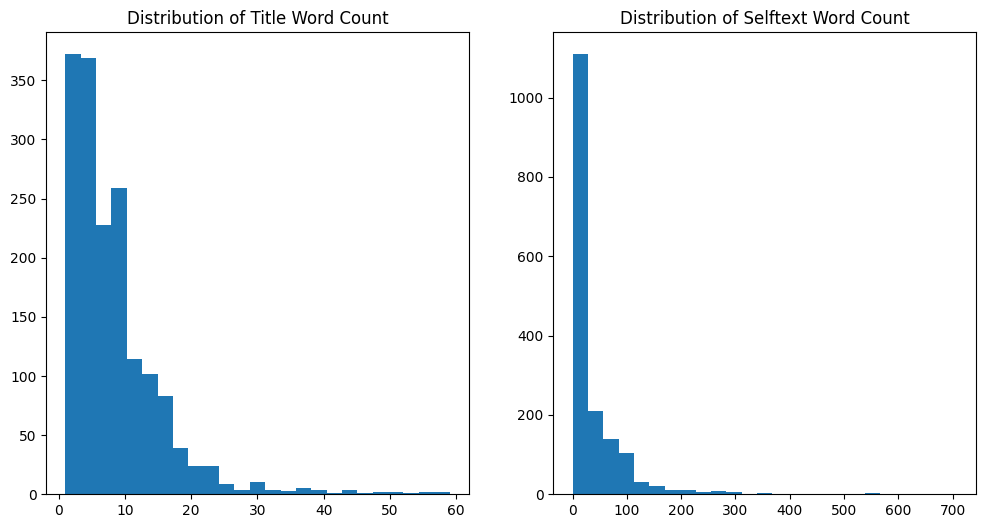

In [20]:
plt.figure(figsize=(12, 6))

cols = ['title_word_count', 'selftext_word_count']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.hist(reddit[cols[i]], bins=25)
    split_words = cols[i].split('_')
    split_words = [i.title() for i in split_words]
    joined_words = ' '.join(split_words)
    plt.title(f'Distribution of {joined_words}')

Despite the 700+ empty-string cells, the selftext_word_count column has a greater mean and max value than the title_word_count column. 

We can also see from the histograms that the distributions for both (combined subreddit) measures is highly skewed. Specifically, the selftext distribution looks to contain most counts between 0 and ~50 words, but the maximum of 708 words (an outlier) is affecting the distribution.

In [21]:
reddit.corr()

,title_word_count,selftext_word_count
title_word_count,1.000000,-0.060429
selftext_word_count,-0.060429,1.000000


There is very weak negative correlation between title word count and caption word count. This is likely partially due to the many null values in the selftext column, but could also imply that those who write long titles do not necessarily write long captions, as well.

In [22]:
'''I'm also going to lowercase all words within the object-type columns before employing CountVectorizer
I know that all context is lowercased by default when using CV
But the values that are checked against the stopwords are not always lowercased, meaning that some stopwords will be missed,
depending on their case in the original post/df
Source: https://github.com/scikit-learn/scikit-learn/issues/19311'''

reddit = reddit.applymap(lambda x: x.lower() if type(x) == str else x)
reddit.rename(columns={'subreddit': 'subreddit_class'}, inplace=True) # Doing this before vectorizing in case the word 'subreddit' is used at all

reddit.head(3)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,ohio,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,ohio,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77


In [23]:
reddit.to_csv('../datasets/reddit_slimmed_no_https.csv')

---
## EDA on Title and SelfText Columns

In [24]:
# Using spacy to lemmatize the title and selftext columns, to then perform EDA
nlp = spacy.load('en_core_web_md')

In [25]:
def lem(sent):
    return ' '.join([x.lemma_ for x in nlp(sent)])

In [26]:
reddit['lem_title'] = reddit['title'].apply(lambda x: lem(x))

In [27]:
# Added 'ohio' and 'state' because these two were included in most posts from 
my_additional_stop_words = ['ohio', 'state', 'x200b', 'img']
new_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

I added 'ohio' and 'state' to the stopwords list because these two were in most posts frmo both subreddit threads and did not provide any valuable information. I removed the other two for further cleaning of the data.

In [28]:
# Count vectorizing here for EDA, but will vectorize again before model trials to avoid data leakage
cvec = CountVectorizer(stop_words=new_stop_words)

reddit_fit = cvec.fit_transform(reddit['lem_title'])

In [29]:
reddit_fit.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [30]:
title_df = pd.DataFrame(reddit_fit.todense(), columns=cvec.get_feature_names_out())

title_df.head()

,000,04,0h10,10,100,10000,1099,10th,10x,11,...,yrg,yugi,yup,zanesville,zero,zimbabwe,zipline,zito,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### What are the 20 most common words used in titles for both subreddits?

In [31]:
top_20_all = title_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_all

hate            80
fuck            53
like            53
look            49
just            49
good            48
bad             47
people          47
unemployment    45
live            44
place           43
make            43
know            35
need            35
think           33
question        32
time            31
year            29
new             29
want            29
dtype: int64

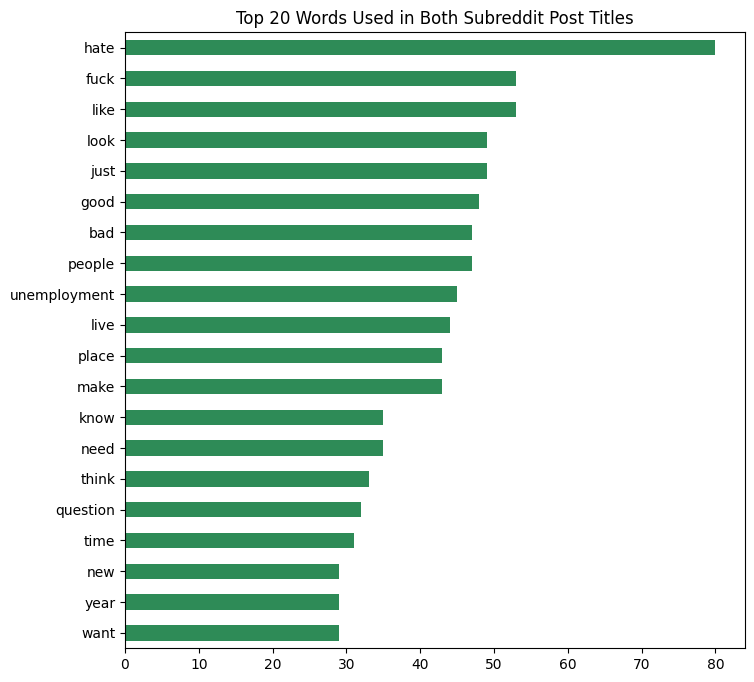

In [32]:
plt.figure(figsize=(8,8))
top_20_all.sort_values(ascending=True).plot.barh(title='Top 20 Words Used in Both Subreddit Post Titles', color='seagreen');

In [33]:
words_and_counts = pd.concat([title_df, reddit], axis=1)
words_and_counts.head(1)

,000,04,0h10,10,100,10000,1099,10th,10x,11,...,zito,zone,zoom,subreddit_class,title,selftext,author,title_word_count,selftext_word_count,lem_title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48,about the donovan lewis police shoot in columbus .


### How about in selftext?

In [34]:
reddit['lem_selftext'] = reddit['selftext'].apply(lambda x: lem(x))

In [35]:
cvec = CountVectorizer(stop_words=new_stop_words)

reddit_st_fit = cvec.fit_transform(reddit['lem_selftext'])

In [36]:
selftext_df = pd.DataFrame(reddit_st_fit.todense(), columns=cvec.get_feature_names_out())

top_20_st = selftext_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_st

just      347
know      241
like      235
people    189
want      177
look      156
place     146
ve        146
say       139
live      137
good      135
time      134
make      129
year      119
think     119
thank     115
try       114
need      114
thing     111
work      111
dtype: int64

Unlike the title, it looks like there are some contractions in the selftext sections of posts. I'm going to filter a few of these out get a better sense of which full words are most present in post captions.

In [37]:
drop_list = ['ve', 'png']
cols_keep = [col for col in selftext_df.columns if col not in drop_list]
selftext_df = selftext_df[cols_keep]

In [38]:
top_20_st = selftext_df.sum(axis=0).sort_values(ascending=False).head(20)

top_20_st

just      347
know      241
like      235
people    189
want      177
look      156
place     146
say       139
live      137
good      135
time      134
make      129
year      119
think     119
thank     115
try       114
need      114
work      111
thing     111
day       105
dtype: int64

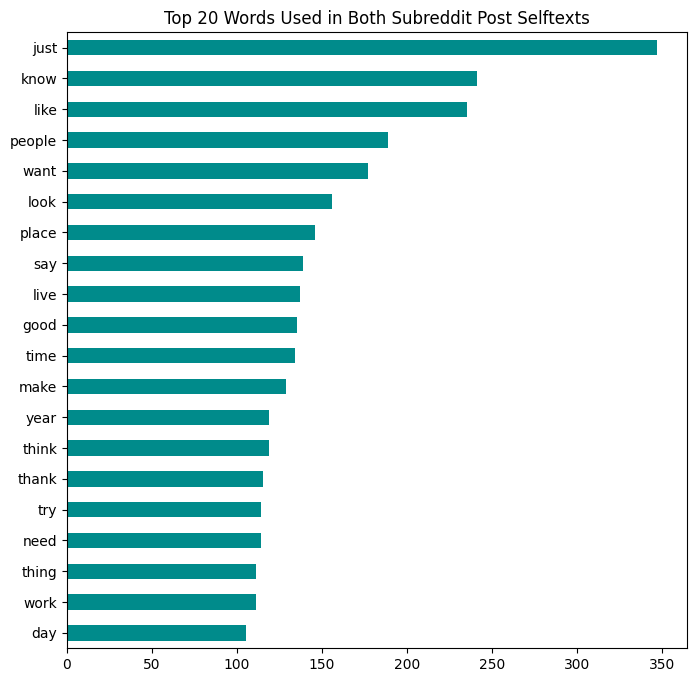

In [39]:
plt.figure(figsize=(8,8))
top_20_st.sort_values(ascending=True).plot.barh(title='Top 20 Words Used in Both Subreddit Post Selftexts', color='darkcyan');

### Did any users post in both subreddit threads?

In [40]:
reddit_auth_cleaned = reddit[reddit['author'] != '[deleted]']

reddit_auth_cleaned[reddit_auth_cleaned.groupby('author')['subreddit_class'].transform('nunique')>1]

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count,lem_title,lem_selftext
752,ohio,i hate ohio?,i just don’t like ohio you know i just hate it bad weather stupid place ahhhh. i mean let’s just firebomb cleveland or cincinnati or just the whole state i just don’t like it stupid place. i’m sha...,kipdu,3,44,I hate ohio ?,I just do not like ohio you know I just hate it bad weather stupid place ahhhh . I mean let ’s just firebomb cleveland or cincinnati or just the whole state I just do not like it stupid place . I ...
935,ihateohio,3000 members,cool little thing guys congrats!,kipdu,2,5,3000 member,cool little thing guy congrat !
986,ihateohio,oh thank god there’s a subreddit for this i just hate ohio so much it’s terrible i’m litterly shaking let’s firebomb cleveland and cincinnati,,kipdu,24,0,oh thank god there ’ a subreddit for this I just hate ohio so much it ’ terrible I ’m litterly shake let ’s firebomb cleveland and cincinnati,
992,ihateohio,oh my gosh i’m so grateful that i’m now a moderator for my favorite subreddit.,,kipdu,15,0,oh my gosh I ’m so grateful that I ’m now a moderator for my favorite subreddit .,
1266,ihateohio,the man...,,kipdu,2,0,the man ...,
1445,ihateohio,can’t wait for ohio to be gone 😊,,kipdu,8,0,can not wait for ohio to be go 😊,


One user posted in both the Ohio and IHateOhio subreddits, but appears to have a strong dislike of the state in all posts.

### What were the top 10 words used separately in each subreddit title?

In [41]:
ohio_top_10 = words_and_counts[words_and_counts['subreddit_class'] == 'ohio'].iloc[:, :-8].sum(axis=0).sort_values(ascending=False).head(10)
hate_ohio_top_10 = words_and_counts[words_and_counts['subreddit_class'] == 'ihateohio'].iloc[:, :-8].sum(axis=0).sort_values(ascending=False).head(10)

In [42]:
top_10_each = pd.concat([ohio_top_10, hate_ohio_top_10])
top_10_each = top_10_each.reset_index().rename(columns={'index': 'word', 0: 'count'})
top_10_each

,word,count
0,unemployment,43
1,look,38
2,good,32
3,need,30
4,question,27
5,place,23
6,know,23
7,people,22
8,vote,19
9,area,18


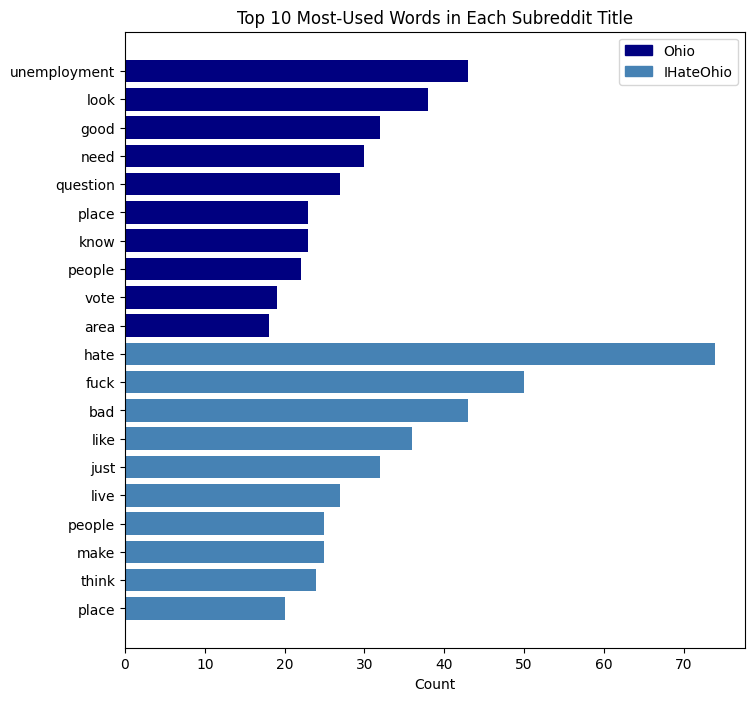

In [43]:
colors = ['navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'navy', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue', 'steelblue']

plt.figure(figsize=(8,8))
plt.barh(y=top_10_each.index[::-1], width=top_10_each['count'], color = colors)
plt.yticks(ticks = top_10_each.index, labels=top_10_each['word'][::-1])
ohio = mpatches.Patch(color='navy', label='Ohio')
hateohio = mpatches.Patch(color='steelblue', label='IHateOhio')
plt.legend(handles=[ohio, hateohio])
plt.xlabel('Count')
plt.title('Top 10 Most-Used Words in Each Subreddit Title');

### Now looking at selftext.

In [44]:
st_words_and_counts = pd.concat([selftext_df, reddit], axis=1)
st_ohio_top_10 = st_words_and_counts[st_words_and_counts['subreddit_class'] == 'ohio'].iloc[:, :-8].sum(axis=0).sort_values(ascending=False).head(10)
st_hate_ohio_top_10 = st_words_and_counts[st_words_and_counts['subreddit_class'] == 'ihateohio'].iloc[:, :-8].sum(axis=0).sort_values(ascending=False).head(10)

In [45]:
st_top_10_each = pd.concat([st_ohio_top_10, st_hate_ohio_top_10])
st_top_10_each = st_top_10_each.reset_index().rename(columns={'index': 'word', 0: 'count'})
st_top_10_each

,word,count
0,just,267
1,know,211
2,like,186
3,want,151
4,look,150
5,people,137
6,say,127
7,time,122
8,place,121
9,good,109


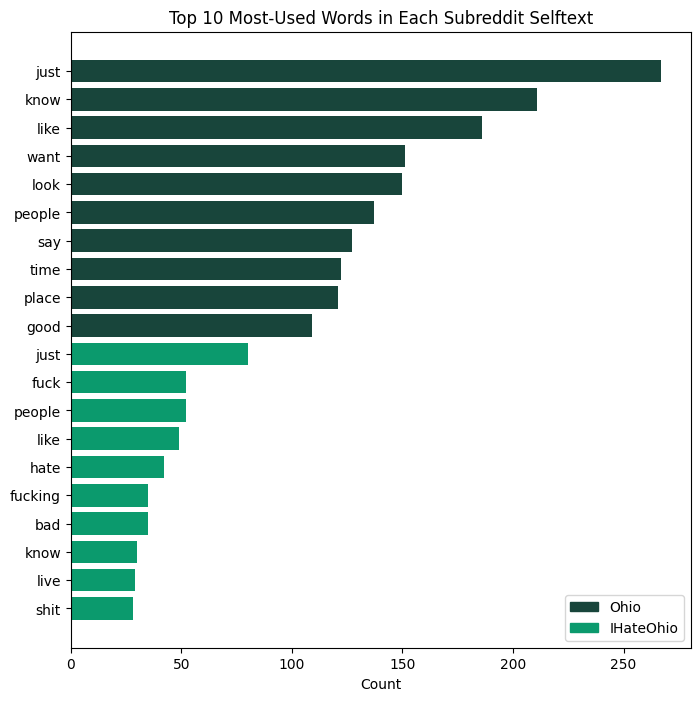

In [46]:
colors = ['#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#18453B', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D', '#0B9A6D']

plt.figure(figsize=(8,8))
plt.barh(y=st_top_10_each.index[::-1], width=st_top_10_each['count'], color = colors)
plt.yticks(ticks = st_top_10_each.index, labels=st_top_10_each['word'][::-1])
ohio = mpatches.Patch(color='#18453B', label='Ohio')
hateohio = mpatches.Patch(color='#0B9A6D', label='IHateOhio')
plt.legend(handles=[ohio, hateohio])
plt.xlabel('Count')
plt.title('Top 10 Most-Used Words in Each Subreddit Selftext');

Similar to the title words, there is a clear difference in those shown in the above bar chart. The IHateOhio subreddit has a number of expletives, while the Ohio captions look to be more centered around opinions and questions.

### What are the most common bigrams in the post titles?

In [47]:
cvec = CountVectorizer(stop_words=new_stop_words, ngram_range=(2,2))

reddit_bi_fit = cvec.fit_transform(reddit['lem_title'])

reddit_bi_fit.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [48]:
bigram_df = pd.DataFrame(reddit_bi_fit.todense(), columns=cvec.get_feature_names_out())

top_10_bigrams = bigram_df.sum(axis=0).sort_values(ascending=False).head(10)

top_10_bigrams

year old           8
break claim        6
hate place         6
fuck fuck          5
absentee ballot    5
high school        5
oh god             5
cedar point        5
road trip          5
speed ticket       5
dtype: int64

In [49]:
cvec = CountVectorizer(stop_words=new_stop_words, ngram_range=(2,2))

reddit_st_bi_fit = cvec.fit_transform(reddit['lem_selftext'])

reddit_st_bi_fit.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [50]:
bigram_st_df = pd.DataFrame(reddit_st_bi_fit.todense(), columns=cvec.get_feature_names_out())

top_10_st_bigrams = bigram_st_df.sum(axis=0).sort_values(ascending=False).head(10)

top_10_st_bigrams

just want        27
thank advance    22
year old         20
feel like        18
let know         16
want know        15
year ago         14
just curious     11
small town       10
look like        10
dtype: int64

### What is the overall sentiment of the titles in each subreddit?

In [51]:
sent = SentimentIntensityAnalyzer()

In [52]:
titles = reddit[['lem_title', 'subreddit_class']]

love_sent = []
hate_sent = []

for i in range(len(titles)):
    if titles['subreddit_class'][i] == 'ohio':
        love_sent.append(sent.polarity_scores(titles['lem_title'][i]))
    else:
        hate_sent.append(sent.polarity_scores(titles['lem_title'][i]))            

In [53]:
love_sent_df = pd.DataFrame.from_dict(love_sent)
hate_sent_df = pd.DataFrame.from_dict(hate_sent)

In [54]:
love_sent_df.describe()

,neg,neu,pos,compound
count,797.000000,797.000000,797.000000,797.000000
mean,0.063181,0.859184,0.077636,0.039269
std,0.148434,0.195805,0.146421,0.311392
min,0.000000,0.000000,0.000000,-0.880700
25%,0.000000,0.741000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.130000,0.077200
max,0.865000,1.000000,1.000000,0.945700


In [55]:
hate_sent_df.describe()

,neg,neu,pos,compound
count,871.000000,871.000000,871.000000,871.000000
mean,0.166279,0.740394,0.093323,-0.107750
std,0.233329,0.253817,0.173837,0.399072
min,0.000000,0.000000,0.000000,-0.977500
25%,0.000000,0.576500,0.000000,-0.502800
50%,0.000000,0.759000,0.000000,0.000000
75%,0.296500,1.000000,0.145000,0.000000
max,1.000000,1.000000,1.000000,0.862500


### What is the overall sentiment of the captions in each subreddit?

In [56]:
sent = SentimentIntensityAnalyzer()

In [57]:
selftexts = reddit[['lem_selftext', 'subreddit_class']]

st_love_sent = []
st_hate_sent = []

for i in range(len(selftexts)):
    if selftexts['subreddit_class'][i] == 'ohio':
        st_love_sent.append(sent.polarity_scores(selftexts['lem_selftext'][i]))
    else:
        st_hate_sent.append(sent.polarity_scores(selftexts['lem_selftext'][i]))     

In [58]:
st_love_sent_df = pd.DataFrame.from_dict(st_love_sent)
st_hate_sent_df = pd.DataFrame.from_dict(st_hate_sent)

In [59]:
st_love_sent_df.describe()

,neg,neu,pos,compound
count,797.000000,797.000000,797.000000,797.000000
mean,0.040390,0.725231,0.083828,0.229967
std,0.061952,0.319992,0.095082,0.539884
min,0.000000,0.000000,0.000000,-0.992800
25%,0.000000,0.746000,0.000000,0.000000
50%,0.011000,0.848000,0.067000,0.128000
75%,0.063000,0.907000,0.131000,0.746400
max,0.481000,1.000000,1.000000,0.999500


In [60]:
st_hate_sent_df.describe()

,neg,neu,pos,compound
count,871.000000,871.000000,871.00000,871.000000
mean,0.045082,0.174366,0.02051,-0.063885
std,0.129271,0.328061,0.07581,0.275363
min,0.000000,0.000000,0.00000,-0.997500
25%,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.00000,0.984900


Referring to the means for each dataframe, it looks like most post titles and captions rank highest on neutrality. The IHateOhio titles had a relatively high mean neutrality score (0.74), while the IHateOhio captions didn't score particularly high on any measure. 

For the sake of analysis and predictions, I'll be using the compound means for each dataframe, as these are described to be the 'normalized, composite score' for each post in [this](https://github.com/cjhutto/vaderSentiment) documentation.

The IHateOhio post titles have the lowest mean compound score, at almost -0.11. On the contrary, the Ohio titles have a relatively impartial score of 0.039. The IHateOhio selftexts have a less impressive mean compound score of -0.064, but the Ohio selftexts have a strong mean of 0.229. All compound score standard deviations are 0.27 or above, meaning that these scores can vary quite a bit and depending on how they vary, could make it easier or harder for the models to classify.

I'll be interested to see if the heavier negative score in the IHateOhio titles make for better predictions, or if the positive skew of the Ohio selftexts will be more effective in modeling.

In [61]:
hate_des = st_hate_sent_df.describe()
hate_des.loc['mean']

neg         0.045082
neu         0.174366
pos         0.020510
compound   -0.063885
Name: mean, dtype: float64

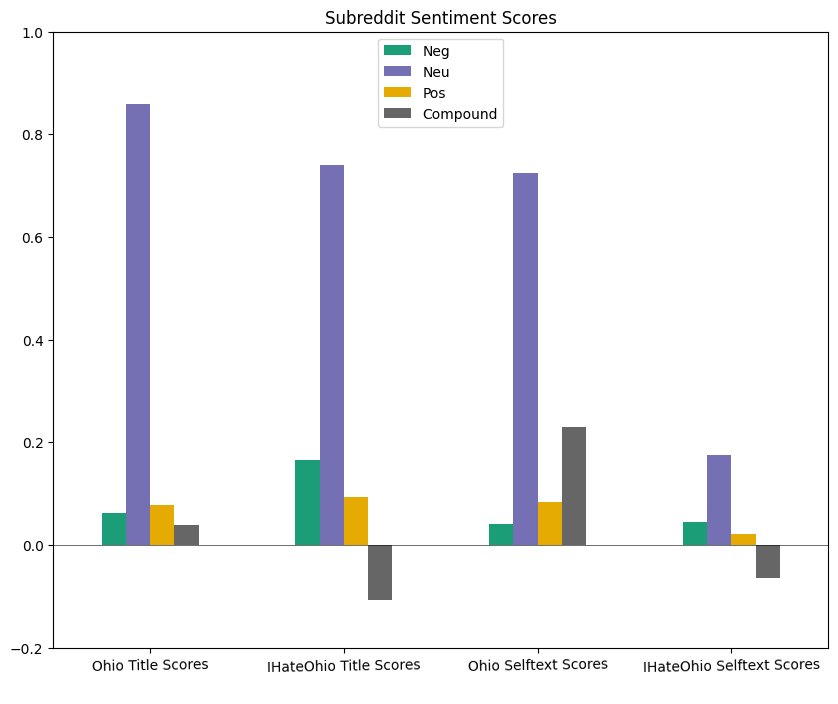

In [62]:
data = [['Ohio Title Scores', 0.063181, 0.859184, 0.077636, 0.039269], ['IHateOhio Title Scores', 0.166279, 0.740394, 0.093323, -0.107750], 
['Ohio Selftext Scores', 0.040390, 0.725231, 0.083828, 0.229967], ['IHateOhio Selftext Scores', 0.045082, 0.174366, 0.02051, -0.063885]]

df = pd.DataFrame(data, columns=['Subreddit', 'Neg', 'Neu', 'Pos', 'Compound'])
df.set_index('Subreddit', inplace=True)

y_tix = [-.2, 0, .2, .4, .6, .8, 1]
df.plot(kind='bar', rot=1, figsize=(10,8), ylim=[-.2, 1], xlabel=' ', colormap='Dark2', title='Subreddit Sentiment Scores', yticks=y_tix)
plt.axhline(y=0, color = 'black', linewidth=0.4)
plt.legend(loc='upper center');

---

## Model Predictions

Going into the model building, I predict the title column to perform better and produce greater test scores than the selftext column. This is because:
- There are no nulls in the title column, but 788 in the selftext column.
- In the graphs above, the most commonly used words are similar among the title and selftext columns. Because there is some resemblance between the two, but less missing data in the title column, I would expect it to be more useful.
- Additionally, I believe the -0.1 mean compound score of the IHateOhio titles will be important in predictions.

With regard to the two subreddit threads, I imagine that the Ohio posts will be somewhat more difficult for most models to classify because there are less strongly-worded phrases.